In [116]:
%pip install qiskit --quiet
%pip install qiskit-aer --quiet
%pip install matplotlib --quiet
%pip install pylatexenc --quiet


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [117]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import GlobalPhaseGate
from qiskit.circuit import Qubit
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
import numpy as np

In [118]:
qa = QuantumRegister(3, 'a')
qb = QuantumRegister(3, 'b')
aux = QuantumRegister(1, 'aux')
z = QuantumRegister(1, 'z')
cr = ClassicalRegister(3, 'c')
qc = QuantumCircuit(qa, qb, aux, z, cr)

qaRegs = qa[:]
qbRegs = qb[:]

# Creating the Quantum Table

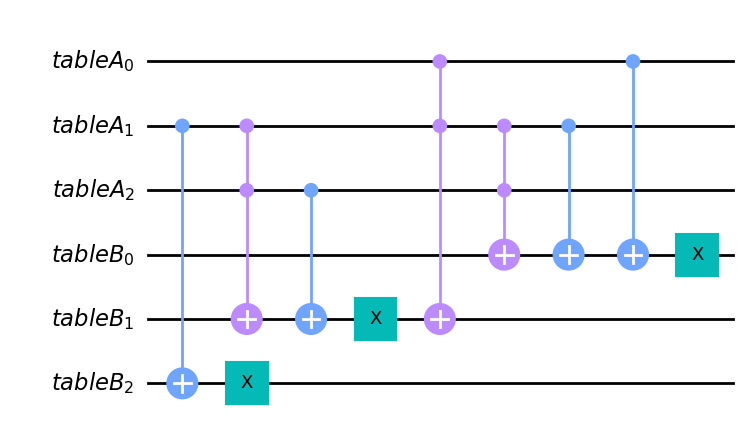

In [132]:
tableA = QuantumRegister(3, 'tableA')
tableB = QuantumRegister(3, 'tableB')
t1 = QuantumCircuit(tableA, tableB)

t1.cx(tableA[1], tableB[2])
t1.x(tableB[2])

t1.ccx(tableA[1], tableA[2], tableB[1])
t1.cx(tableA[2], tableB[1])
t1.x(tableB[1])
t1.ccx(tableA[0], tableA[1], tableB[1])

t1.ccx(tableA[1], tableA[2], tableB[0])
t1.cx(tableA[1], tableB[0])
t1.cx(tableA[0], tableB[0])
t1.x(tableB[0])


table1 = t1.to_gate(label='table1')
t1.draw(output='mpl')


## Performing a search (SELECT query)

100


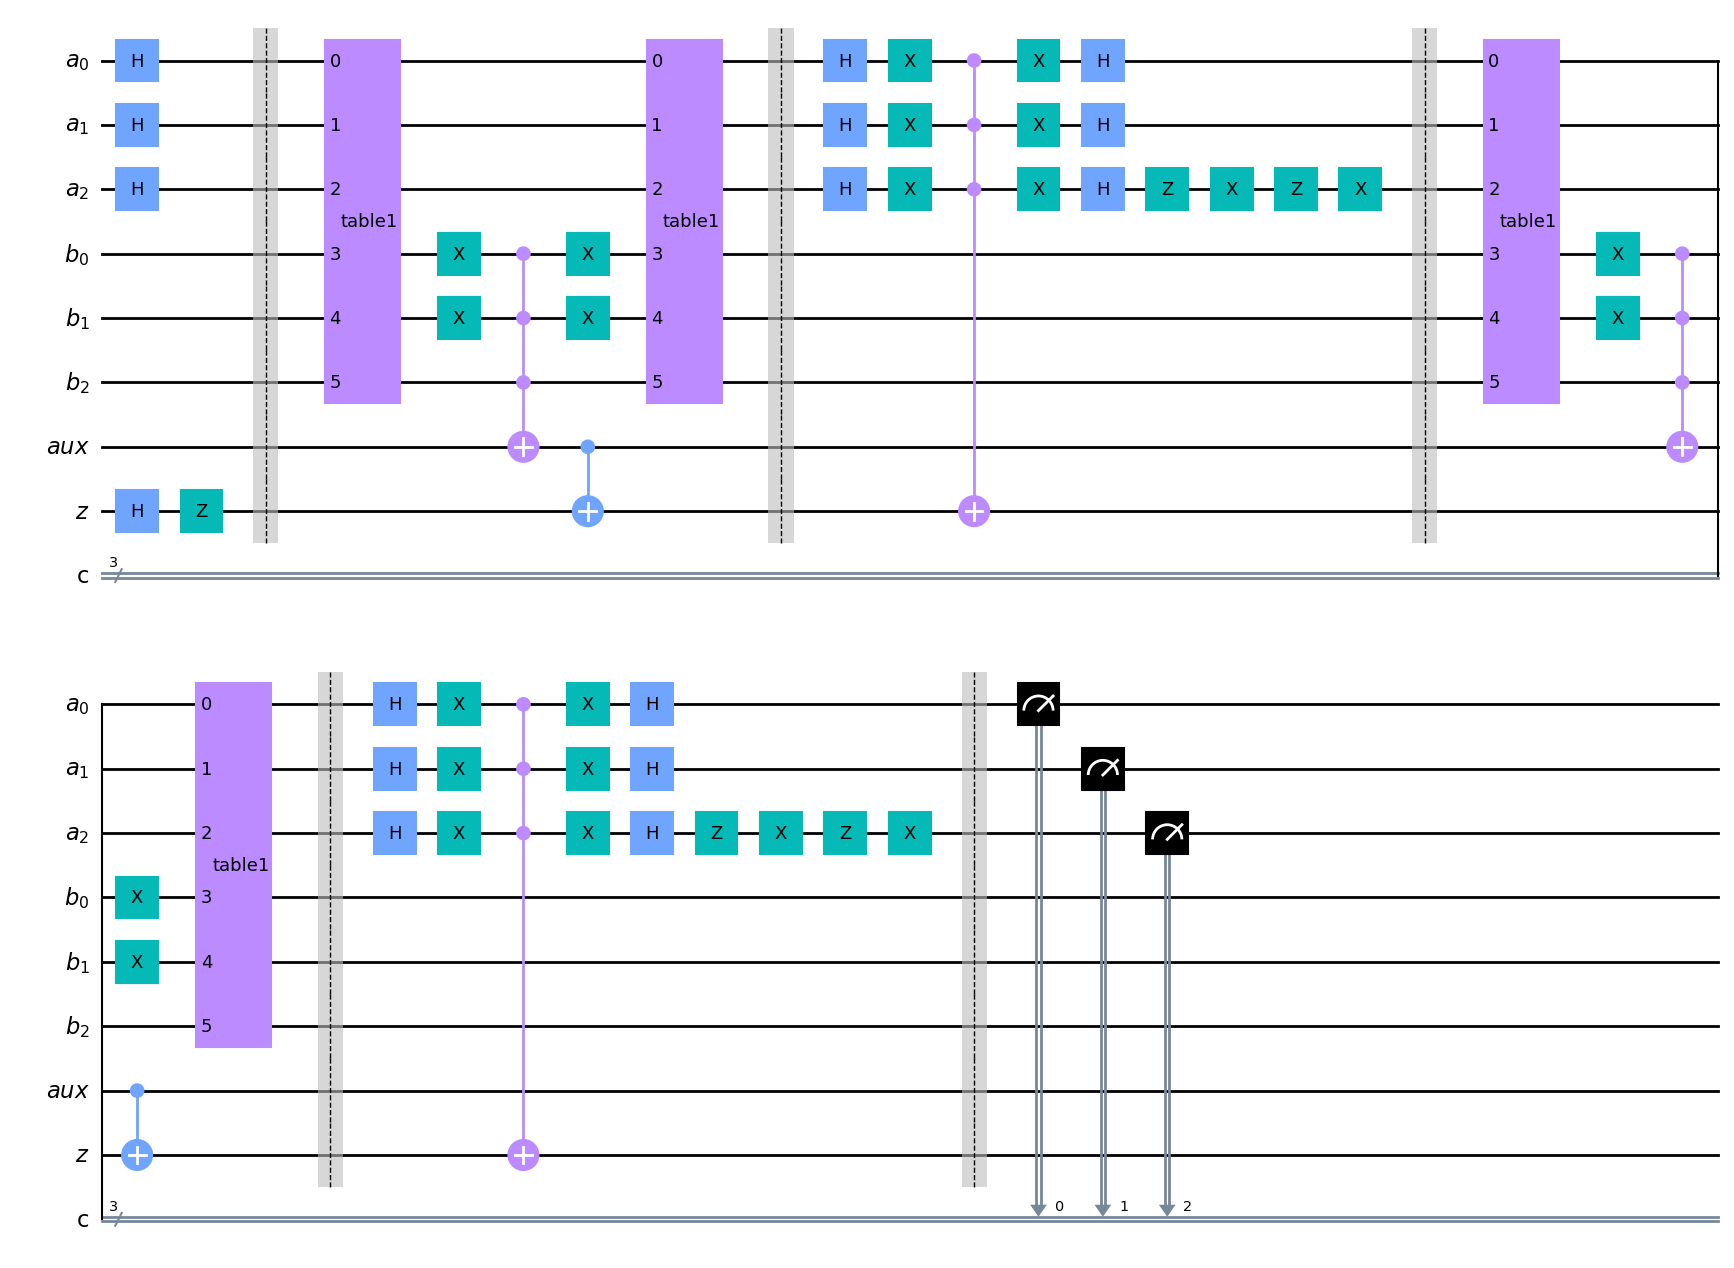

In [120]:
# Let's search for qb = 4, should get 101 (5) as output\
def search(num):
    qa = QuantumRegister(3, 'a')
    qb = QuantumRegister(3, 'b')
    aux = QuantumRegister(1, 'aux')
    z = QuantumRegister(1, 'z')
    cr = ClassicalRegister(3, 'c')
    qc = QuantumCircuit(qa, qb, aux, z, cr)

    qaRegs = qa[:]
    qbRegs = qb[:]

    M = int(np.floor(np.pi/4 * np.sqrt(2**len(qaRegs))))
    binary = bin(num)[2:]
    binary = '0'*(len(qa)-len(binary)) + binary
    print(binary)
    # qc.add_register(z)
    # qc.x(z)
    qc.h(z)
    qc.z(z)
    # qc.p(np.pi, z)
    qc.h(qaRegs)
    qc.barrier()
    for i in range(M):
        qc.append(table1, qaRegs[:] + qbRegs[:])
        for j in range(len(binary)):
            if binary[j] == '0':
                qc.x(qbRegs[len(binary)-j-1])
        # qc.x(qb[2])
        # qc.x(qbRegs[1])
        # qc.x(qbRegs[0])
        qc.mcx(qbRegs, aux)
        for j in range(len(binary)):
            if binary[j] == '0':
                qc.x(qbRegs[len(binary)-j-1])

            
        qc.append(table1, qaRegs[:] + qbRegs[:])
        qc.cx(aux, z)
        qc.barrier()
        # qc.x(qb[2])
        # qc.x(qbRegs[1])
        # qc.x(qbRegs[0])
        # qc.cx(aux, qaRegs)
        # qc.ch(aux, qaRegs)
        qc.h(qaRegs)
        qc.x(qaRegs)
        qc.mcx(qaRegs, z)
        qc.x(qaRegs)
        qc.h(qaRegs)
        # qc.ch(z, qa)
        qc.z(qaRegs[len(qaRegs)-1])
        qc.x(qaRegs[len(qaRegs)-1])
        qc.z(qaRegs[len(qaRegs)-1])
        qc.x(qaRegs[len(qaRegs)-1])
        qc.barrier()

    # qc.h(qa)
    # qc.x(qaRegs)
    qc.measure(qa, cr)
    return qc
    
searchCircuit = search(4)
searchCircuit.draw(output='mpl')

{'100': 6, '111': 2, '011': 2, '110': 4, '101': 22, '010': 5, '000': 5, '001': 4}


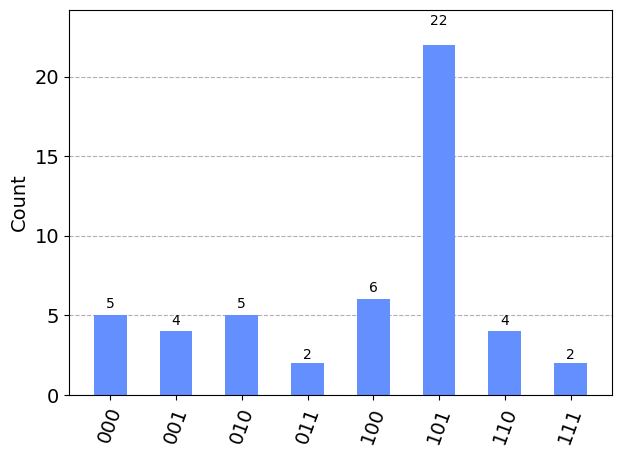

In [121]:
backend = Aer.get_backend('qasm_simulator')
job = execute(searchCircuit, backend, shots=50)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

## Performing an Insert (INSERT query)

{'0001': 72, '1010': 55, '1101': 67, '0110': 141, '0100': 137, '0101': 66, '0010': 79, '0000': 55, '1011': 63, '0111': 117, '0011': 60, '1001': 63, '1000': 49}


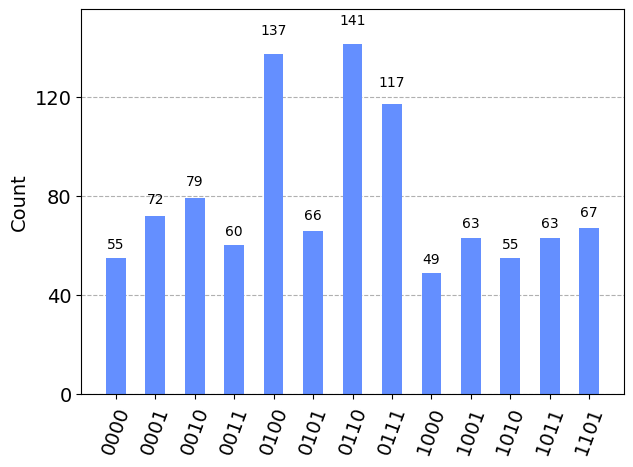

In [130]:
def insert():
    qa = QuantumRegister(3, 'a')
    qb = QuantumRegister(3, 'b')
    aux = QuantumRegister(1, 'aux')
    z = QuantumRegister(1, 'z')
    cr = ClassicalRegister(4, 'c')
    qc = QuantumCircuit(qa, qb, aux, z, cr)

    qaRegs = qa[:]
    qbRegs = qb[:]

    qc.h(qaRegs)
    qc.append(table1, qaRegs[:] + qbRegs[:])

    # Inserting 8 into table
    qa1 = QuantumRegister(1, 'a1')
    qb1 = QuantumRegister(1, 'b1')
    qc.add_register(qa1)
    qc.add_register(qb1)
    qaRegs += qa1[:]
    qbRegs += qb1[:]

    # Stage 1: Controlling on prev states
    qc.x(qaRegs)
    qc.mcx(qaRegs, aux)
    qc.x(qaRegs)

    qc.x(qaRegs[1:])
    qc.mcx(qaRegs, aux)
    qc.x(qaRegs[1:])

    qc.x(qaRegs[2:] + [qaRegs[0]])
    qc.mcx(qaRegs, aux)
    qc.x(qaRegs[2:] + [qaRegs[0]])

    qc.x(qaRegs[2:])
    qc.mcx(qaRegs, aux)
    qc.x(qaRegs[2:])

    qc.x([qaRegs[1], qaRegs[3]])
    qc.mcx(qaRegs, aux)
    qc.x([qaRegs[1], qaRegs[3]])

    qc.ch(aux, qaRegs[3])
    qc.barrier()

    # Stage 2
    qc.x(qaRegs)
    qc.mcx(qaRegs, aux)
    qc.x(qaRegs)

    qc.x(qaRegs[1:])
    qc.mcx(qaRegs, aux)
    qc.x(qaRegs[1:])

    qc.x(qaRegs[2:])
    qc.mcx(qaRegs, aux)
    qc.x(qaRegs[2:])

    qc.x(qaRegs[0:1] + [qaRegs[3]])
    qc.mcx(qaRegs, aux)
    qc.x(qaRegs[0:1] + [qaRegs[3]])

    qc.x([qaRegs[1], qaRegs[3]])
    qc.mcx(qaRegs, aux)
    qc.x([qaRegs[1], qaRegs[3]])

    qc.barrier()

    # Stage 3
    qc.x(qaRegs[0:3])
    qc.mcx(qaRegs[:] + aux[:], qbRegs[2])
    qc.x(qaRegs[0:3])

    # Stage 4
    qc.x(qaRegs[0:3])
    qc.mcx(qaRegs, aux)
    qc.x(qaRegs[0:3])

    qc.draw(output='mpl')
    qc.measure(qaRegs, cr)

    return qc

insertCircuit = insert()
insertCircuit.draw(output='mpl')

backend = Aer.get_backend('qasm_simulator')
job = execute(insertCircuit, backend, shots=1024)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)


## Creating a new Table

In [123]:
c = QuantumRegister(2, 'c')
d = QuantumRegister(2, 'd')
e = QuantumRegister(3, 'e')
t2 = QuantumCircuit(c, d, e)

t2.h(c)
t2.cx(c[1], d[1])
t2.cx(c[0], d[1])
t2.x(d[1])
